In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
plt.style.use('default')

a = np.random.seed(42)

In [ ]:
plt.rcParams['figure.figsize'] = [7, 5]

#### pre-processing

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/IIIT/II/DL/Concrete_Data.xls')

In [ ]:
n_data = (data - data.mean())/data.std()

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(n_data, test_size=0.3)

In [ ]:
target_name = data.columns[-1]
y_train = train[target_name].to_numpy()
x_train = train.drop(target_name, axis=1).to_numpy()
y_test = test[target_name].to_numpy()
x_test = test.drop(target_name, axis=1).to_numpy()

#### Functions

In [ ]:
def LeReLu(x):
  x[x < 0] = 0.01*x[x<0]
  return x

def DLeReLu(x):
  x[x >= 0] = 1
  x[x < 0] = 0.01
  return x

In [ ]:
def forward2(W_1, b_1, W_2, b_2, x):
    z_1 = np.matmul(W_1, x.reshape(-1, 1)) + b_1
    y_1 = LeReLu(z_1)

    z_2 = np.matmul(W_2, y_1) + b_2
    y_2 = z_2.copy()

    return y_2, z_2, y_1, z_1

def backward2(W, y_2, z_2, y_1, z_1, x, y):


    [W_2, b_2, W_1, b_1] = W
    DL_y2 = (y_2 - y)
    DL_z2 = DL_y2.copy()

    DL_W2 = np.matmul(y_1, DL_z2)
    DL_b2 = DL_z2.copy()

    # Dloss_W2 += DL_W2
    # Dloss_b2 += DL_b2

    # print(DL_y2.shape, DL_W2.shape, DL_b2.shape)

    Jy1_z1 = np.diag(DLeReLu(z_1).reshape(-1,))

    DL_y1 = np.matmul(DL_z2, W_2)
    DL_z1 = np.matmul(DL_y1, Jy1_z1)

    DL_W1 = np.matmul(x.reshape(-1, 1), DL_z1)
    DL_b1 = DL_z1.copy()

    # Dloss_W1 += DL_W1
    # Dloss_b1 += DL_b1

    return DL_W2, DL_b2, DL_W1, DL_b1

In [ ]:
def forward(W_1, b_1, W_2, b_2, x):
    z_1 = np.matmul(W_1, x.reshape(-1, 1)) + b_1
    y_1 = np.tanh(z_1)

    z_2 = np.matmul(W_2, y_1) + b_2
    y_2 = z_2.copy()

    return y_2, z_2, y_1, z_1

In [ ]:
def backward(W, y_2, z_2, y_1, z_1, x, y):

  [W_2, b_2, W_1, b_1] = W
  DL_y2 = (y_2-y)
  DL_z2 = DL_y2.copy()

  DL_W2 = np.matmul(y_1, DL_z2)
  DL_b2 = DL_z2.copy()

  # Dloss_W2 += DL_W2
  # Dloss_b2 += DL_b2


  Jy1_z1 = np.diag((1-np.tanh(z_1)**2).reshape(-1,))
  # print(Jy1_z1.shape)

  DL_y1 = np.matmul(DL_z2, W_2)
  DL_z1 = np.matmul(DL_y1, Jy1_z1)

  DL_W1 = np.matmul(x.reshape(-1, 1), DL_z1)
  DL_b1 = DL_z1.copy()

  # Dloss_W1 += DL_W1
  # Dloss_b1 += DL_b1

  return DL_W2, DL_b2, DL_W1, DL_b1

In [ ]:
def c_plot(result, text):

  xh = range(1,1001)
  plt.plot(np.asarray(result[0])/len(x_train), linestyle='dashed', label='train')
  plt.plot(np.asarray(result[1])/len(x_test), color = 'red', alpha=0.7, label='test')
  plt.title(text)
  plt.legend()
  plt.show()

#### Batch GD

In [ ]:
def BackProp(W, x_train, activation):
  loss = 0
  Dloss_W2 = 0
  Dloss_b2 = 0

  Dloss_W1 = 0
  Dloss_b1 = 0

  [W_2, b_2, W_1, b_1] = W
  for i in range(len(x_train)):

    if activation == 0:
      y_2, z_2, y_1, z_1  = forward(W_1, b_1, W_2, b_2, x_train[i])
      DL_W2, DL_b2, DL_W1, DL_b1 = backward(W, y_2, z_2, y_1, z_1, x_train[i], y_train[i])
    else:
      y_2, z_2, y_1, z_1  = forward2(W_1, b_1, W_2, b_2, x_train[i])
      DL_W2, DL_b2, DL_W1, DL_b1 = backward2(W, y_2, z_2, y_1, z_1, x_train[i], y_train[i])

    loss += (0.5)*(y_2 - y_train[i])**2

    Dloss_W2 += DL_W2
    Dloss_b2 += DL_b2
    Dloss_W1 += DL_W1
    Dloss_b1 += DL_b1

  return Dloss_W1, Dloss_b1, Dloss_W2, Dloss_b2, loss

In [ ]:
def update(W_1, b_1, W_2, b_2, Dloss_W1, Dloss_b1, Dloss_W2, Dloss_b2, eta=1e-3, T=len(x_train)):
  m = eta/T
  W_1 -= m*Dloss_W1.T
  b_1 -= m*Dloss_b1.T

  W_2 -= m*Dloss_W2.T
  b_2 -= m*Dloss_b2.T
  return W_1, b_1, W_2, b_2

In [ ]:
def run_BackProp(x_train, x_test, n_hidden, activation):

  W_2 = np.random.rand(1, n_hidden)
  b_2 = np.random.rand(1,1)
  W_1 = np.random.rand(n_hidden, 8)
  b_1 = np.random.rand(n_hidden,1)

  loss_tr = []
  loss_te = []
  t = 0
  convg = 1000

  for j in range(1000):

    s = time.time()
    Dloss_W1, Dloss_b1, Dloss_W2, Dloss_b2, loss = BackProp([W_2, b_2,W_1, b_1], x_train, activation)
    W_1, b_1, W_2, b_2 = update(W_1, b_1, W_2, b_2, Dloss_W1, Dloss_b1, Dloss_W2, Dloss_b2)
    e = time.time()
    t += e-s

    loss_tr.append(loss[0][0])
    if j > 2 and np.abs(loss_tr[-1]-loss_tr[-2]) < 0.1:
      convg = j

    loss_test = 0
    for k in range(len(x_test)):
      if activation == 0:
        pred, _, _, _ = forward(W_1, b_1, W_2, b_2, x_test[k])
      else:
        pred, _, _, _ = forward2(W_1, b_1, W_2, b_2, x_test[k])
      loss_test += (0.5)*(pred - y_test[k])**2
    loss_te.append(loss_test[0][0])

  return [loss_tr, loss_te, t, convg]

In [ ]:
results1025 = run_BackProp(x_train, x_test, n_hidden=25, activation=0)
results1125 = run_BackProp(x_train, x_test, n_hidden=25, activation=1)

results1050 = run_BackProp(x_train, x_test, n_hidden=50, activation=0)
results1150 = run_BackProp(x_train, x_test, n_hidden=50, activation=1)

In [ ]:
print('          Min Loss        Train   Test')
print('25 hidden units, tanh  : {:.2f}  {:.2f}'.format(min(results1025[0]), min(results1025[1])))
print('25 hidden units, LeReLu: {:.2f}  {:.2f}'.format(min(results1125[0]), min(results1125[1])))
print('50 hidden units, tanh  : {:.2f}  {:.2f}'.format(min(results1050[0]), min(results1050[1])))
print('50 hidden units, LeReLu: {:.2f}  {:.2f}'.format(min(results1150[0]), min(results1150[1])))

          Min Loss        Train   Test
25 hidden units, tanh  : 166.81  77.55
25 hidden units, LeReLu: 247.05  113.11
50 hidden units, tanh  : 228.02  102.92
50 hidden units, LeReLu: 254.43  125.44


##### Plots

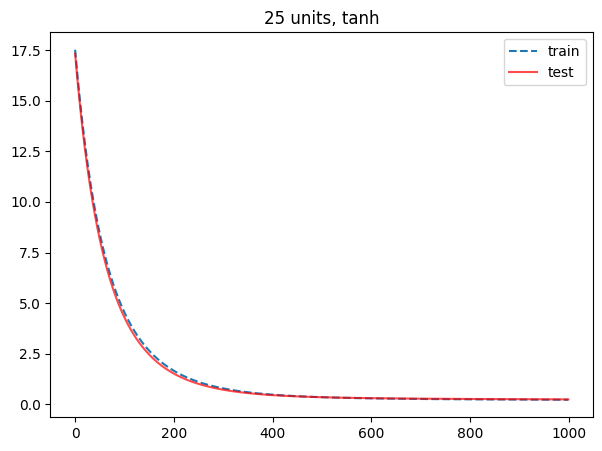

In [ ]:
c_plot(results1025, '25 units, tanh')

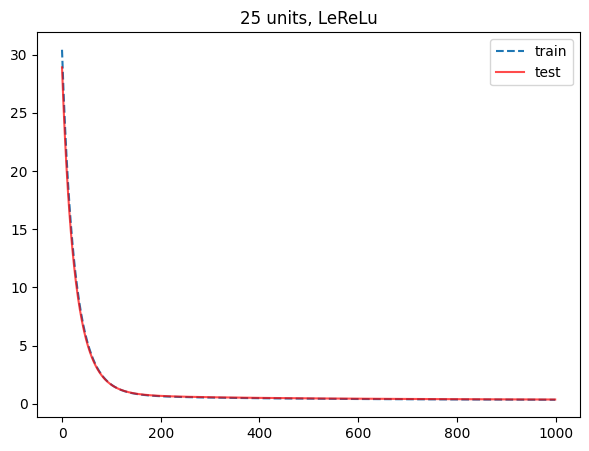

In [ ]:
c_plot(results1125, '25 units, LeReLu')

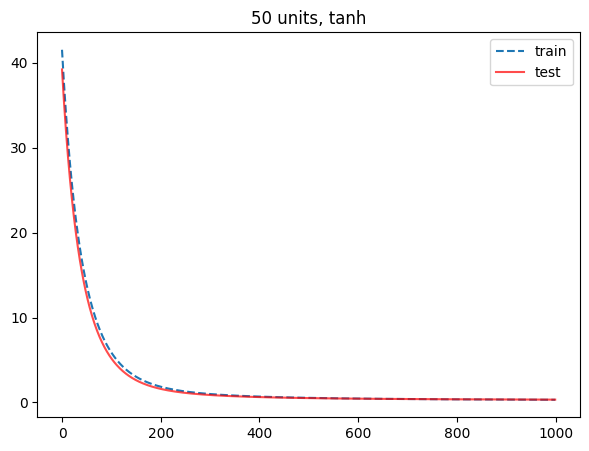

In [ ]:
c_plot(results1050, '50 units, tanh')

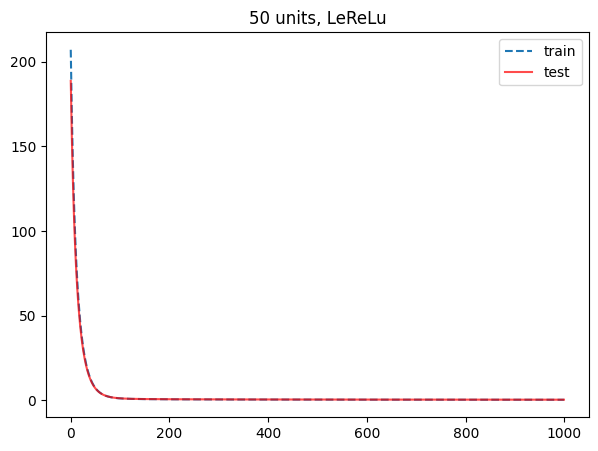

In [ ]:
c_plot(results1150, '50 units, LeReLu')

#### RProp

In [ ]:
def update1(pDL, DL, delta, W, alpha, beta, max, min):

  [W_2, b_2, W_1, b_1] = W
  [delta_W2, delta_b2, delta_W1, delta_b1] = delta

  [pDL_W2, pDL_b2, pDL_W1, pDL_b1] = pDL
  [DL_W2, DL_b2, DL_W1, DL_b1] = DL

  [W2_max, b2_max, W1_max, b1_max] = max
  [W2_min, b2_min, W1_min, b1_min] = min

  # W2
  p_idx = np.where(np.sign(np.multiply(pDL_W2, DL_W2)) == 1.)[0]
  n_idx = np.where(np.sign(np.multiply(pDL_W2, DL_W2)) == -1.)[0]

  delta_W2[p_idx] = np.minimum(alpha*delta_W2[p_idx], W2_max*np.ones_like(delta_W2[p_idx]))
  pDL_W2[p_idx] = DL_W2[p_idx]

  W_2[:, n_idx] += delta_W2[n_idx].T
  delta_W2[n_idx] = np.maximum(beta*delta_W2[n_idx], W2_min*np.ones_like(delta_W2[n_idx]))


  # b2
  p_idx0, p_idx1 = np.where(np.sign(np.multiply(pDL_b2, DL_b2)) == 1.)
  n_idx0, n_idx1 = np.where(np.sign(np.multiply(pDL_b2, DL_b2)) == -1.)

  delta_b2[p_idx0, p_idx1] = np.minimum(alpha*delta_b2[p_idx0, p_idx1], b2_max*np.ones_like(delta_b2[p_idx0, p_idx1]))
  pDL_b2[p_idx0, p_idx1] = DL_b2[p_idx0, p_idx1]

  b_2[n_idx1, n_idx0] += delta_b2[n_idx0, n_idx1].T
  delta_b2[n_idx0, n_idx1] = np.maximum(beta*delta_b2[n_idx0, n_idx1], b2_min*np.ones_like(delta_b2[n_idx0, n_idx1]))


  # W1
  p_idx0, p_idx1 = np.where(np.sign(np.multiply(pDL_W1, DL_W1)) == 1.)
  n_idx0, n_idx1 = np.where(np.sign(np.multiply(pDL_W1, DL_W1)) == -1.)

  delta_W1[p_idx0, p_idx1] = np.minimum(alpha*delta_W1[p_idx0, p_idx1], W1_max*np.ones_like(delta_W1[p_idx0, p_idx1]))
  pDL_W1[p_idx0, p_idx1] = DL_W1[p_idx0, p_idx1]

  W_1[n_idx1, n_idx0] += delta_W1[n_idx0, n_idx1].T
  delta_W1[n_idx0, n_idx1] = np.maximum(beta*delta_W1[n_idx0, n_idx1], W1_min*np.ones_like(delta_W1[n_idx0, n_idx1]))


  # b1
  p_idx0, p_idx1 = np.where(np.sign(np.multiply(pDL_b1, DL_b1)) == 1.)
  n_idx0, n_idx1 = np.where(np.sign(np.multiply(pDL_b1, DL_b1)) == -1.)

  delta_b1[p_idx0, p_idx1] = np.minimum(alpha*delta_b1[p_idx0, p_idx1], b1_max*np.ones_like(delta_b1[p_idx0, p_idx1]))
  pDL_b1[p_idx0, p_idx1] = DL_b1[p_idx0, p_idx1]

  b_1[n_idx1, n_idx0] += delta_b1[n_idx0, n_idx1].T
  delta_b1[n_idx0, n_idx1] = np.maximum(beta*delta_b1[n_idx0, n_idx1], b1_min*np.ones_like(delta_b1[n_idx0, n_idx1]))

  return [W_2, b_2, W_1, b_1], [delta_W2, delta_b2, delta_W1, delta_b1], [pDL_W2, pDL_b2, pDL_W1, pDL_b1]

In [ ]:
def Rprop(x_train, y_train, W, activation, alpha = 1.05, beta = 0.3):

  [W_2, b_2, W_1, b_1] = W

  x = x_train[0]
  y = y_train[0]
  # y_2, z_2, y_1, z_1 = forward(W_1, b_1, W_2, b_2, x)
  # DL_W2, DL_b2, DL_W1, DL_b1 = backward(y_2, z_2, y_1, z_1, x, y)
  if activation == 0:
    y_2, z_2, y_1, z_1 = forward(W_1, b_1, W_2, b_2, x)
    DL_W2, DL_b2, DL_W1, DL_b1 = backward(W, y_2, z_2, y_1, z_1, x, y)
  else:
    y_2, z_2, y_1, z_1 = forward2(W_1, b_1, W_2, b_2, x)
    DL_W2, DL_b2, DL_W1, DL_b1 = backward2(W, y_2, z_2, y_1, z_1, x, y)

  delta_b1 = (5e-5)*np.ones_like(DL_b1)
  b1_max = 1e-2
  b1_min = 1e-7
  delta_W1 = (5e-5)*np.ones_like(DL_W1)
  W1_max = 1e-2
  W1_min = 1e-7
  delta_W2 = (5e-5)*np.ones_like(DL_W2)
  W2_max = 1e-2
  W2_min = 1e-7
  delta_b2 = (5e-5)*np.ones_like(DL_b2)
  b2_max = 1e-2
  b2_min = 1e-7

  max = [W2_max, b2_max, W1_max, b1_max]
  min = [W2_min, b2_min, W1_min, b1_min]

  pDL_W1 = DL_W1
  pDL_W2 = DL_W2
  pDL_b1 = DL_b1
  pDL_b2 = DL_b2

  delta_W1 = np.multiply(np.sign(DL_W1), delta_W1)
  delta_W2 = np.multiply(np.sign(DL_W2), delta_W2)
  delta_b1 = np.multiply(np.sign(DL_b1), delta_b1)
  delta_b2 = np.multiply(np.sign(DL_b2), delta_b2)

  loss = 0
  loss += (y_2 - y_train[0])**2

  for i in range(1, len(x_train)):

    W_1 -= delta_W1.T
    W_2 -= delta_W2.T
    b_1 -= delta_b1.T
    b_2 -= delta_b2.T

    W = [W_2, b_2, W_1, b_1]
    if activation == 0:
      y_2, z_2, y_1, z_1 = forward(W_1, b_1, W_2, b_2, x_train[i])
      DL_W2, DL_b2, DL_W1, DL_b1 = backward(W, y_2, z_2, y_1, z_1, x_train[i], y_train[i])
    else:
      y_2, z_2, y_1, z_1 = forward2(W_1, b_1, W_2, b_2, x_train[i])
      DL_W2, DL_b2, DL_W1, DL_b1 = backward2(W, y_2, z_2, y_1, z_1, x_train[i], y_train[i])
    # y_2, z_2, y_1, z_1 = forward(W_1, b_1, W_2, b_2, x_train[i])
    # DL_W2, DL_b2, DL_W1, DL_b1 = backward(y_2, z_2, y_1, z_1, x_train[i], y_train[i])
    loss += (0.5)*(y_2 - y_train[i])**2

    W = [W_2, b_2, W_1, b_1]
    delta = [delta_W2, delta_b2, delta_W1, delta_b1]
    pDL = [pDL_W2, pDL_b2, pDL_W1, pDL_b1]
    DL = [DL_W2, DL_b2, DL_W1, DL_b1]

    W, delta, pDL = update1(pDL, DL, delta, W, alpha, beta, max, min)

    [W_2, b_2, W_1, b_1] = W
    [delta_W2, delta_b2, delta_W1, delta_b1] = delta
    [pDL_W2, pDL_b2, pDL_W1, pDL_b1] = pDL

  return W, loss

In [ ]:
def run_RProp(x_train, y_train, n_hidden, activation):

  # weight intializations
  W_1 = np.random.rand(n_hidden, 8)
  b_1 = np.random.rand(n_hidden,1)

  W_2 = np.random.rand(1, n_hidden)
  b_2 = np.random.rand(1,1)

  loss_tr = [np.inf]
  loss_te = []
  t = 0
  convg = 1000

  loss_list = []
  for j in range(1000):
    W = [W_2, b_2, W_1, b_1]
    s = time.time()
    [W_2, b_2, W_1, b_1], loss = Rprop(x_train, y_train, W, activation)
    e = time.time()
    t += (e-s)
    # print('epoch:', j)
    # print(W_2)
    # if j % 100 == 0:
    #   print(loss[0][0])
    #   print(W_2, '\n')
    #   print(b_2, '\n')
    #   print(W_1.T, '\n')
    #   print(b_1.T)
    loss_tr.append(loss[0][0])
    if np.abs(loss_tr[-1]-loss_tr[-2]) < 10:
      convg = j

    loss_test = 0
    for k in range(len(x_test)):
      if activation == 0:
        pred, _, _, _ = forward(W_1, b_1, W_2, b_2, x_test[k])
      else:
        pred, _, _, _ = forward2(W_1, b_1, W_2, b_2, x_test[k])
      loss_test += (0.5)*(pred - y_test[k])**2
      loss_te.append(loss_test[0][0])

  return [loss_tr, loss_te, t, convg]

In [ ]:
results2050 = run_RProp(x_train, y_train, n_hidden=50, activation=0)
results2150 = run_RProp(x_train, y_train, n_hidden=50, activation=1)
results2025 = run_RProp(x_train, y_train, n_hidden=25, activation=0)
results2125 = run_RProp(x_train, y_train, n_hidden=25, activation=1)

In [ ]:
print('          Min Loss        Train   Test')
print('25 hidden units, tanh  : {:.2f}  {:.2f}'.format(min(results2025[0]), min(results2025[1])))
print('25 hidden units, LeReLu: {:.2f}  {:.2f}'.format(min(results2125[0]), min(results2125[1])))
print('50 hidden units, tanh  : {:.2f}  {:.2f}'.format(min(results2050[0]), min(results2050[1])))
print('50 hidden units, LeReLu: {:.2f}  {:.2f}'.format(min(results2150[0]), min(results2150[1])))

          Min Loss        Train   Test
25 hidden units, tanh  : 2837.93  30.54
25 hidden units, LeReLu: 7484.13  252.02
50 hidden units, tanh  : 9687.23  91.33
50 hidden units, LeReLu: 25485.43  752.55


##### plots

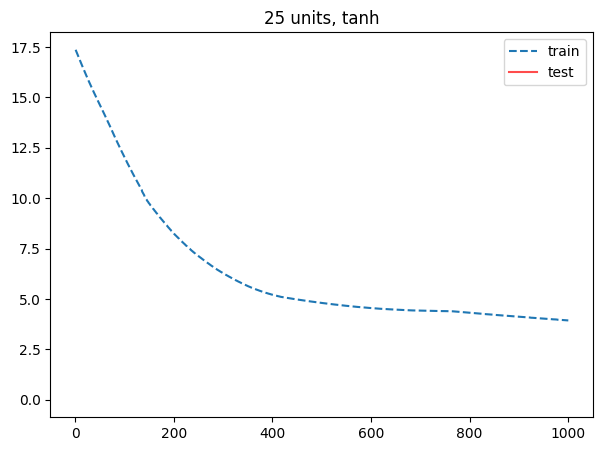

In [ ]:
c_plot([results2025[0], 0], '25 units, tanh')

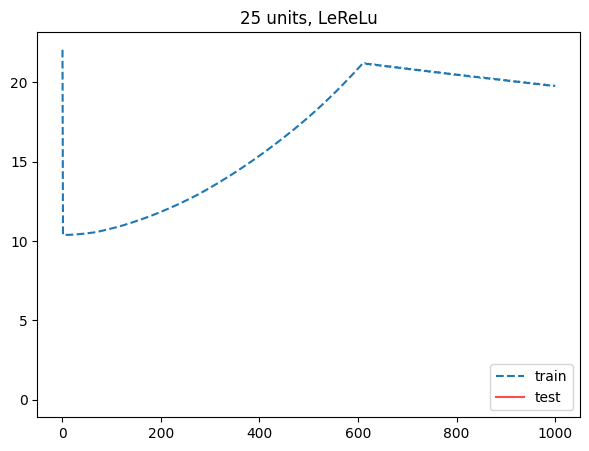

In [ ]:
c_plot([results2125[0], 0], '25 units, LeReLu')

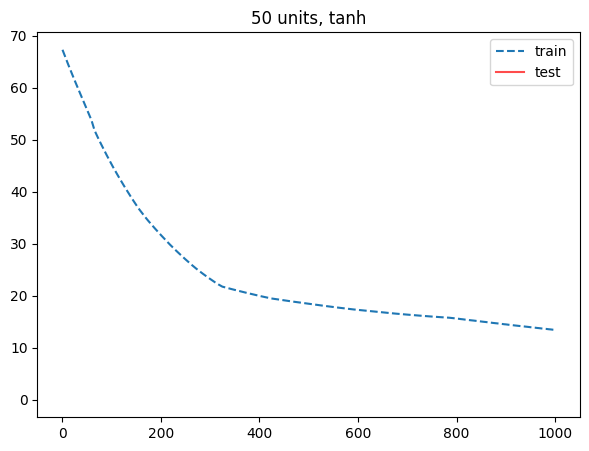

In [ ]:
c_plot([results2050[0], 0], '50 units, tanh')

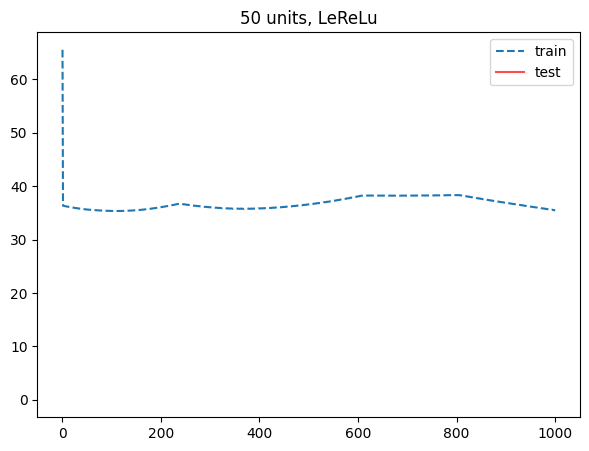

In [ ]:
c_plot([results2150[0], 0], '50 units, LeReLu')

###### tr-te

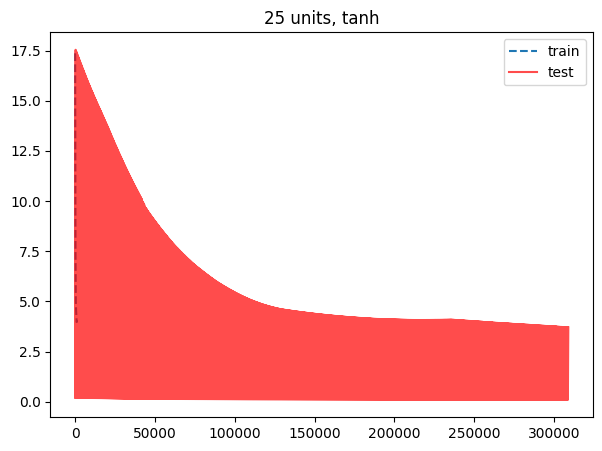

In [ ]:
c_plot(results2025, '25 units, tanh')

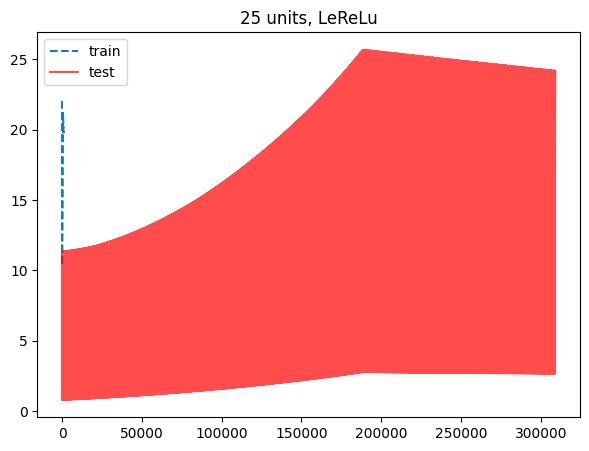

In [ ]:
c_plot(results2125, '25 units, LeReLu')

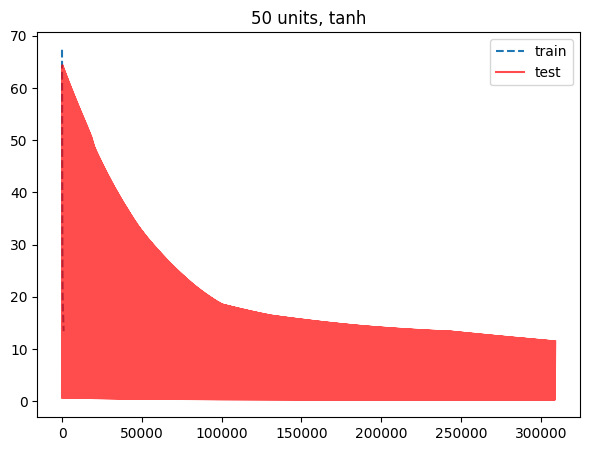

In [ ]:
c_plot(results2050, '50 units, tanh')

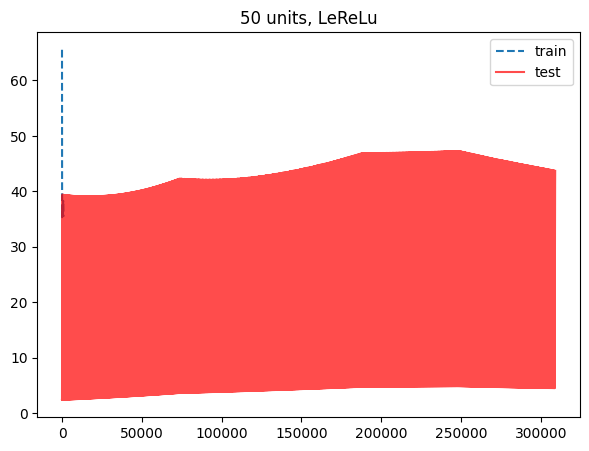

In [ ]:
c_plot(results2150, '50 units, LeReLu')

#### QuickProp

In [ ]:
def QuickProp(x_train, y_train, W, prevW, prevD, n_hidden, activation):

  [W_2, b_2, W_1, b_1] = W
  [prev_W2, prev_b2, prev_W1, prev_b1] = prevW
  [prevDL_W2, prevDL_b2, prevDL_W1, prevDL_b1] = prevD

  loss = 0
  for i in range(len(x_train)):

    W = [W_2, b_2, W_1, b_1]
    if activation == 0:
      y_2, z_2, y_1, z_1 = forward(W_1, b_1, W_2, b_2, x_train[i])
      DL_W2, DL_b2, DL_W1, DL_b1 = backward(W, y_2, z_2, y_1, z_1, x_train[i], y_train[i])
    else:
      y_2, z_2, y_1, z_1 = forward2(W_1, b_1, W_2, b_2, x_train[i])
      DL_W2, DL_b2, DL_W1, DL_b1 = backward2(W, y_2, z_2, y_1, z_1, x_train[i], y_train[i])

    loss += (0.5)*(y_2 - y_train[i])**2

    # 2nd order approximation
    mW2 = np.divide((W_2 - prev_W2), (DL_W2 - prevDL_W2).T)
    mb2 = np.divide((b_2 - prev_b2), (DL_b2 - prevDL_b2).T)
    mW1 = np.divide((W_1 - prev_W1), (DL_W1 - prevDL_W1).T)
    mb1 = np.divide((b_1 - prev_b1), (DL_b1 - prevDL_b1).T)

    prev_W1 = W_1
    prev_b1 = b_1
    prev_W2 = W_2
    prev_b2 = b_2

    # update
    W_2 -= np.multiply(mW2, DL_W2.T)
    b_2 -= np.multiply(mb2, DL_b2.T)
    W_1 -= np.multiply(mW1, DL_W1.T)
    b_1 -= np.multiply(mb1, DL_b1.T)

    prevDL_W1 = prevDL_W1
    prevDL_b1 = prevDL_b1
    prevDL_W2 = prevDL_W2
    prevDL_b2 = prevDL_b2

  W = [W_2, b_2, W_1, b_1]
  prevW = [prev_W2, prev_b2, prev_W1, prev_b1]
  prevD = [prevDL_W2, prevDL_b2, prevDL_W1, prevDL_b1]

  return W, prevW, prevD, loss

In [ ]:
def run_QuickProp(x_train, x_test, n_hidden, activation):

  W_1 = np.random.rand(n_hidden, 8)
  b_1 = np.random.rand(n_hidden,1)
  W_2 = np.random.rand(1, n_hidden)
  b_2 = np.random.rand(1,1)

  prev_W1 = np.zeros((n_hidden, 8))
  prev_b1 = np.zeros((n_hidden,1))
  prev_W2 = np.zeros((1, n_hidden))
  prev_b2 = np.zeros((1,1))

  prevDL_W1 = np.random.rand(8, n_hidden)
  prevDL_b1 = np.random.rand(1, n_hidden)
  prevDL_W2 = np.random.rand(n_hidden, 1)
  prevDL_b2 = np.random.rand(1, 1)

  loss_tr = [np.inf]
  loss_te = []
  t = 0
  convg = 1000

  for j in range(1000):
    W = [W_2, b_2, W_1, b_1]
    prevW = [prev_W2, prev_b2, prev_W1, prev_b1]
    prevD = [prevDL_W2, prevDL_b2, prevDL_W1, prevDL_b1]

    s = time.time()
    W, prevW, prevD, loss = QuickProp(x_train, y_train, W, prevW, prevD, n_hidden, activation)
    e = time.time()
    t += (e-s)

    loss_tr.append(loss[0][0])
    if np.abs(loss_tr[-1]-loss_tr[-2]) < 0.1:
      convg = j

    [W_2, b_2, W_1, b_1] = W
    loss_test = 0
    for k in range(len(x_test)):
      if activation == 0:
        pred, _, _, _ = forward(W_1, b_1, W_2, b_2, x_test[k])
      else:
        pred, _, _, _ = forward2(W_1, b_1, W_2, b_2, x_test[k])
      loss_test += (0.5)*(pred - y_test[k])**2
    loss_te.append(loss_test[0][0])

  return [loss_tr, loss_te, t, convg]

In [ ]:
results3025 = run_QuickProp(x_train, x_test, n_hidden=25, activation=0)
results3125 = run_QuickProp(x_train, x_test, n_hidden=25, activation=1)

results3050 = run_QuickProp(x_train, x_test, n_hidden=50, activation=0)
results3150 = run_QuickProp(x_train, x_test, n_hidden=50, activation=1)

In [ ]:
print('          Min Loss        Train   Test')
print('25 hidden units, tanh  : {:.2f}  {:.2f}'.format(min(results3025[0]), min(results3025[1])))
print('25 hidden units, LeReLu: {:.2f}  {:.2f}'.format(min(results3125[0]), min(results3125[1])))
print('50 hidden units, tanh  : {:.2f}  {:.2f}'.format(min(results3050[0]), min(results3050[1])))
print('50 hidden units, LeReLu: {:.2f}  {:.2f}'.format(min(results3150[0]), min(results3150[1])))

          Min Loss        Train   Test
25 hidden units, tanh  : 444.70  163.11
25 hidden units, LeReLu: 364.45  150.18
50 hidden units, tanh  : 371.14  143.86
50 hidden units, LeReLu: 10852.99  3717.03


##### Plots

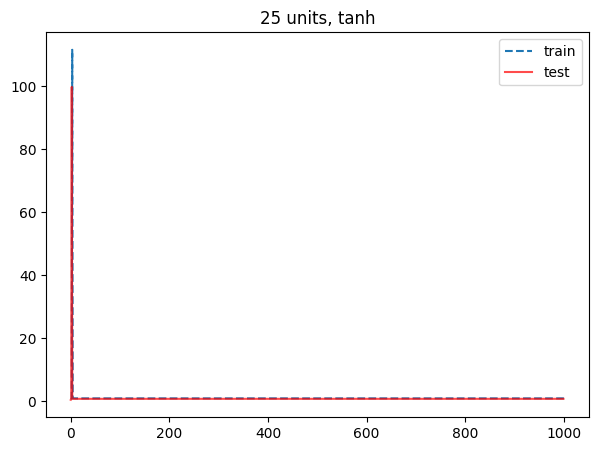

In [ ]:
c_plot(results3025, '25 units, tanh')

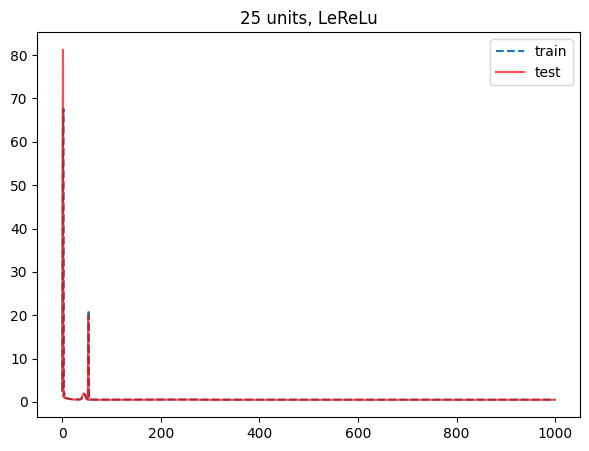

In [ ]:
c_plot(results3125, '25 units, LeReLu')

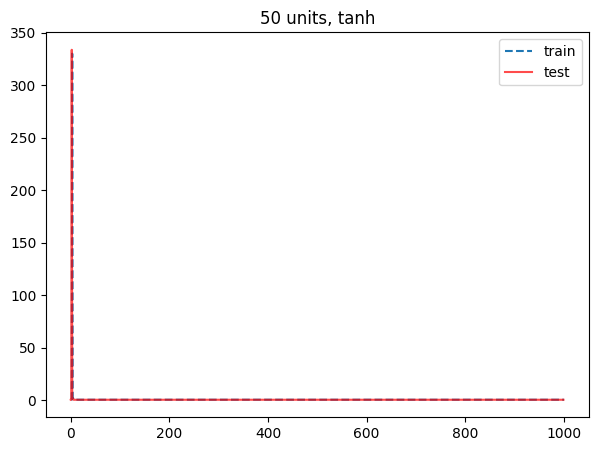

In [ ]:
c_plot(results3050, '50 units, tanh')

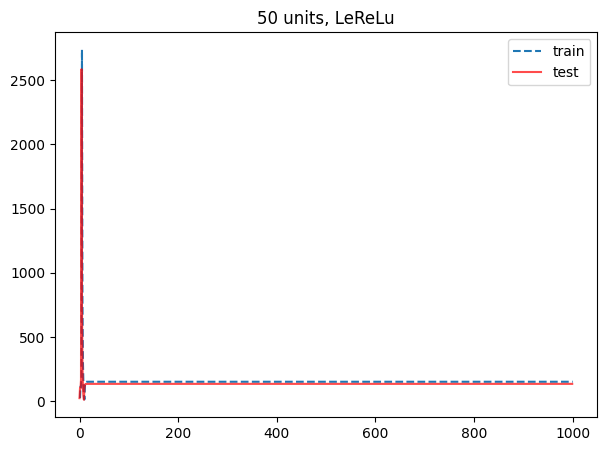

In [ ]:
c_plot(results3150, '50 units, LeReLu')

#### Results

In [ ]:
t_25d = [[min(results1025[0]), min(results1025[1]), results1025[3], results1025[2]],
  [min(results2025[0]), min(results2025[1]), results2025[3], results2025[2]],
  [min(results3025[0]), min(results3025[1]), results3025[3], results3025[2]]]

r_25d = [[min(results1125[0]), min(results1125[1]), results1125[3], results1125[2]],
  [min(results2125[0]), min(results2125[1]), results2125[3], results2125[2]],
  [min(results3125[0]), min(results3125[1]), results3125[3], results3125[2]]]

t_50d = [[min(results1050[0]), min(results1050[1]), results1050[3], results1050[2]],
  [min(results2050[0]), min(results2050[1]), results2050[3], results2050[2]],
  [min(results3050[0]), min(results3050[1]), results3050[3], results3050[2]]]

r_50d = [[min(results1150[0]), min(results1150[1]), results1150[3], results1150[2]],
  [min(results2150[0]), min(results2150[1]), results2150[3], results2150[2]],
  [min(results3150[0]), min(results3150[1]), results3150[3], results3150[2]]]

In [ ]:
cols = ['train loss','test loss', 'epochs', 'time (per epoch)']
rows = ['BackProp', 'Rprop', 'QuickProp']
t_25 = pd.DataFrame(t_25d, columns=cols, index=rows)
r_25 = pd.DataFrame(r_25d, columns=cols, index=rows)
t_50 = pd.DataFrame(t_50d, columns=cols, index=rows)
r_50 = pd.DataFrame(r_50d, columns=cols, index=rows)

In [ ]:
t = pd.concat([t_25, t_50], keys=[25, 50])
r = pd.concat([r_25, r_50], keys=[25, 50])

In [ ]:
rs = pd.concat([t,r], keys=['tanh', 'leaky relu'])

In [74]:
print(rs)

                           train loss    test loss  epochs  time (per epoch)
tanh       25 BackProp     166.806189    77.549817     999         41.684493
              Rprop       2837.929394    30.543784     999        234.336194
              QuickProp    444.703275   163.113337     999         73.339887
           50 BackProp     228.017701   102.915986    1000         46.644860
              Rprop       9687.225838    91.326312     998        270.115348
              QuickProp    371.141335   143.855002     999         67.105226
leaky relu 25 BackProp     247.052699   113.114400     999         52.374515
              Rprop       7484.132983   252.017414     999        247.920203
              QuickProp    364.447386   150.177465     999         71.062019
           50 BackProp     254.427480   125.443726     999         52.886692
              Rprop      25485.429557   752.547267     997        263.636907
              QuickProp  10852.991687  3717.033765     999         73.317055

In [ ]:
rs.rename_axis(['Activation Function', 'Hidden Units', 'Algorithm'])

train loss    test loss  epochs  \
Activation Function Hidden Units Algorithm                                      
tanh                25           BackProp     166.806189    77.549817     999   
                                 Rprop       2837.929394    30.543784     999   
                                 QuickProp    444.703275   163.113337     999   
                    50           BackProp     228.017701   102.915986    1000   
                                 Rprop       9687.225838    91.326312     998   
                                 QuickProp    371.141335   143.855002     999   
leaky relu          25           BackProp     247.052699   113.114400     999   
                                 Rprop       7484.132983   252.017414     999   
                                 QuickProp    364.447386   150.177465     999   
                    50           BackProp     254.427480   125.443726     999   
                                 Rprop      25485.429557   752.547267     997   
                                 QuickProp  10852.991687  3717.033765     999   

                                            time (per epoch)  
Activation Function Hidden Units Algorithm                    
tanh                25           BackProp          41.684493  
                                 Rprop            234.336194  
                                 QuickProp         73.339887  
                    50           BackProp          46.644860  
                                 Rprop            270.115348  
                                 QuickProp         67.105226  
leaky relu          25           BackProp          52.374515  
                                 Rprop            247.920203  
                                 QuickProp         71.062019  
                    50           BackProp          52.886692  
                                 Rprop            263.636907  
                                 QuickProp         73.317055